# VPfits

The VPfits module contains a class, `VPfit`, that carries out most of the heavy lifting. First we create an instance of this class.

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.lines as mlines

import pymc as mc

import pandas as pd
import numpy as np

import datetime

from scipy.signal import savgol_filter

In [3]:
import vpfits
from physics import *

In [4]:
vpfit = vpfits.VPfit()

## Mock Spectra

`VPfit` contains a function for creating mock absoprtion profiles, `mock_absorption`. Just tell it how many features you wish to include. It returns a dataframe, `clouds`, containing each feature, and an array of wavelength values. It can also plot the profile.

If you wish to create mock voigt profiles, set the `voigt` parameter to true.

vpfits.py:506: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  clouds.loc[cloud]['amplitude'], clouds.loc[cloud]['L'], clouds.loc[cloud]['G']))


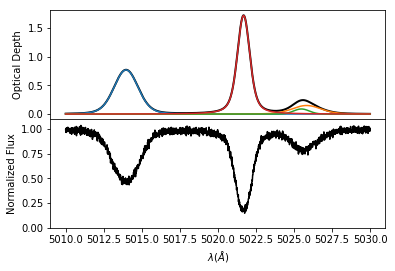

In [5]:
n = 4

#clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True)

clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True, voigt=True)

The plot shows the profile with added noise, but right now the function doesn't return this composite noisy profile, so we recreate it as `flux_array`.

In [6]:
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

noise_vector = np.array([onesigmaerror]*len(noise))
flux_array = Tau2flux(sum(clouds['tau'])) + noise
flux_array[flux_array < 0] = 0

## Find Local Minima

In [7]:
window=101

local_minima = vpfit.find_local_minima(flux_array, window=window)

/home/sarah/miniconda2/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/sarah/miniconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


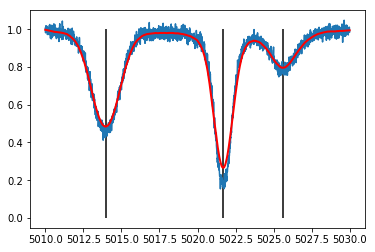

In [8]:
pylab.plot(wavelength_array, flux_array)
pylab.plot(wavelength_array, savgol_filter(flux_array, window, 1), 'red', lw=2)

local_minima = vpfit.find_local_minima(flux_array)

pylab.vlines(wavelength_array[local_minima], 0, 1)

## Fitting

To fit, initialise the model with `n` profiles, calculate the MAP estimate, then run the MCMC.

If you wish to fit Voigt profiles, set the `voigt` flag to True (be aware that the VPfit Voigt profile implementation consists of an extra parameter relative to the Gaussian, and will take longer to converge, especially for complicated profiles).

In [9]:
vpfit.initialise_model(wavelength_array, flux_array, n, local_minima, voigt=True)

In [10]:
vpfit.map_estimate()

In [11]:
vpfit.mcmc_fit(iterations=10000, burnin=5000)

Using Adaptive Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 158.2 sec
Took: 0:02:38.206456  to finish.


Our `VPfit` instance, `vpfit`, now contains the fitted profile components.

## Convergence

We can assess whether the chain has converged using a number of different formal diagnostics provided by PyMC. 

*The Geweke diagnostic often fails with an opaque error, especially if the chains are very far from convergence.*

In [12]:
alpha_scores = mc.geweke(vpfit.mcmc, intervals=20)

mc.Matplot.geweke_plot(alpha_scores)

LinAlgError: Singular matrix

In [13]:
rl_convergence = mc.raftery_lewis(vpfit.mcmc, q=0.995, r=0.05, verbose=True)
rl_convergence


Diagnostic for est_L_3 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

2 iterations to be discarded at the beginning of the simulation (burn-in).

10 subsequent iterations required.

Thinning factor of 1 required to produce an independence chain.

Diagnostic for xexp_2 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

2 iterations to be discarded at the beginning of the simulation (burn-in).

10 subsequent iterations required.

Thinning factor of 1 required to produce an independence chain.

Diagnostic for est_L_2 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce 

{'est_G_0': (8, 1, 2, 10, 1),
 'est_G_1': (8, 1, 10, 28, 2),
 'est_G_2': (8, 1, 2, 10, 1),
 'est_G_3': (8, 1, 2, 10, 1),
 'est_L_0': (8, 1, 10, 28, 2),
 'est_L_1': (8, 1, 10, 28, 2),
 'est_L_2': (8, 1, 2, 10, 1),
 'est_L_3': (8, 1, 2, 10, 1),
 'est_centroid_0': (8, 1, 10, 28, 2),
 'est_centroid_1': (8, 1, 2, 5, 1),
 'est_centroid_2': (8, 1, 2, 5, 1),
 'est_centroid_3': (8, 1, 10, 28, 2),
 'sd': (8, 1, 2, 10, 1),
 'xexp_0': (8, 1, 10, 28, 2),
 'xexp_1': (8, 1, -2147483648, -2147483648, 1),
 'xexp_2': (8, 1, 2, 10, 1),
 'xexp_3': (8, 1, 1, 1, 1)}

## Model Selection

We can query some features of the fit useful for model selection, such as the Maximum A Posteriori (MAP) Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).

In [14]:
print vpfit.map.BIC
print vpfit.map.AIC

-9693.75100483993
-9788.96634665


We also have model selection metrics from the MCMC

In [15]:
print vpfit.mcmc.BPIC
print vpfit.mcmc.DIC

-9856.542109001897
-9846.173217387704


The class instance also has functions for calculating both the $\chi^2$ and the reduced chi-squared, $\chi_{r}^{2}$.

In [16]:
vpfits.VPfit.Chisquared(vpfit.total.value, flux_array, noise_vector)

2152.3893315518244

In [17]:
vpfits.VPfit.ReducedChisquared(vpfit.total.value, flux_array, noise_vector, len(vpfit.estimated_variables))

538.0973328879561

## Plotting

Finally, we can also plot the fit, with residuals. The fitted components and actual components can be directly compared.

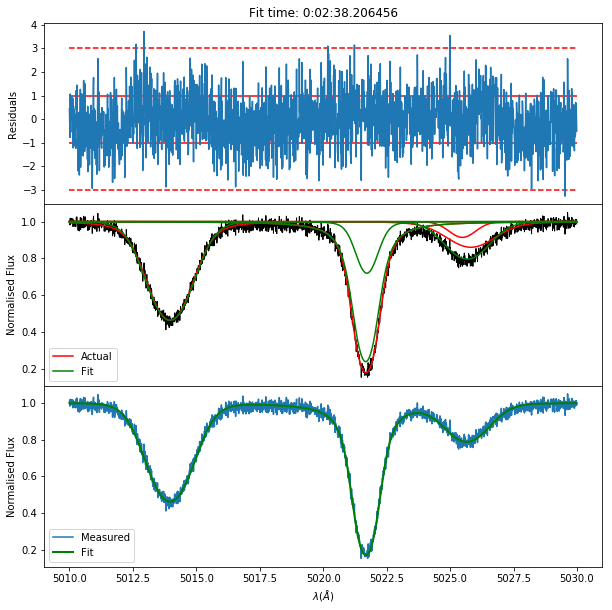

In [18]:
vpfit.plot(wavelength_array, flux_array, clouds, n=n)

# Region Detection

Regions are detected based on a detection threshold of 4 sigma. The number of pixels needed below the threshold to divide regions is set with `buffer`, and the minimum width of a region is set with `min_region_width` in pixels.

The `compute_detection_regions` function outputs a numpy array of the start and end wavelengths of each region.

In [21]:
min_region_width = 5
regions, pixels = vpfits.compute_detection_regions(wavelength_array, flux_array, noise_vector, 
                                           min_region_width = min_region_width)

print regions

Computing detection regions...
Found 3 detection regions.
[[5011.75 5016.19]
 [5019.28 5019.51]
 [5019.46 5027.76]]


We then construct arrays containing the delimiting pixels and wavelength values for each region

In [22]:
region_arrays = []
region_pixels = []

for region in regions:
    
    start = np.where(wavelength_array==region[0])[0][0]
    end = np.where(wavelength_array==region[1])[0][0]
    
    region_pixels.append([start, end])
    region_arrays.append([wavelength_array[start:end], flux_array[start:end]])

We can now plot each region.

In [23]:
def plot_bracket(x, dir):
    height = .2
    arm_length = 0.2
    pylab.plot((x, x), (1-height/2, 1+height/2), color='magenta')
    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length
    pylab.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    pylab.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

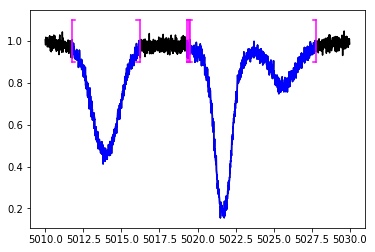

In [24]:
pylab.plot(wavelength_array, flux_array, c='black')

for arr in region_arrays:
    pylab.plot(arr[0], arr[1], color='blue')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')
    
pylab.show()

## Finding the right number of profiles

In a complicated spectrum, knowing how many components there are can be difficult. `VPfits` can perform model selection on two fits with different numbers of profiles to determine which is the best.

Below is an early implementation using the Bayesian Information Criterion (BIC) as a threshold.

n:  2
Fit 1 BIC:  -2096.712105322646 , Fit 2 BIC:  -2159.18080384438
Fit 1 CS: 5.142988648554069e-08

/home/sarah/miniconda2/lib/python2.7/site-packages/pymc/CommonDeterministics.py:849: RuntimeWarning: invalid value encountered in log
  'b': lambda a, b: np.log(a) * a ** b}


 | Fit 2 CS: 3.094395239470719e-08
BIC Ratio:  0.9710683336890965
n:  3
Fit 1 BIC:  -2159.18080384438 , Fit 2 BIC:  -2143.079481360287
Fit 1 CS: 3.094395239470719e-08 | Fit 2 CS: 3.0488217813271975e-08
BIC Ratio:  1.0075131709412257
Using Adaptive Metropolis step method for each parameter.
 [-----------------100%-----------------] 15000 of 15000 complete in 13.1 sec
Took: 0:00:13.073272  to finish.


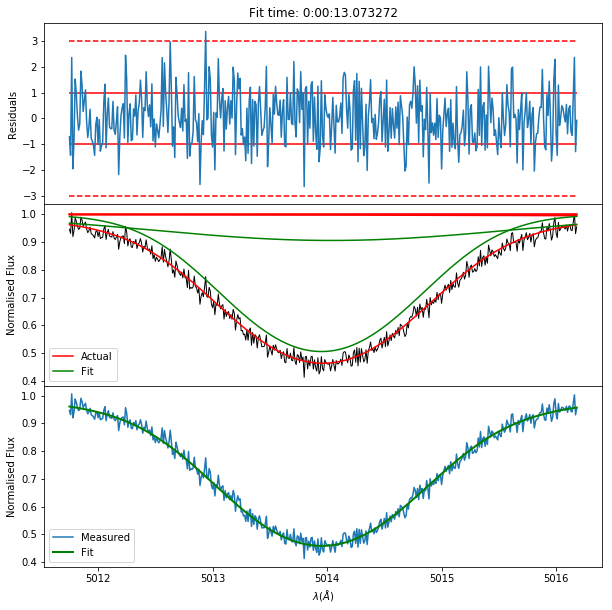

n:  2
Fit 1 BIC:  -71.47108902569681 , Fit 2 BIC:  -87.71782593967708
Fit 1 CS: 8.039117158290141e-08 | Fit 2 CS: 2.8726078493789617e-09
BIC Ratio:  0.8147840904635161
n:  3
Fit 1 BIC:  -87.71782593967708 , Fit 2 BIC:  -53.6616053392587
Fit 1 CS: 2.8726078493789617e-09 | Fit 2 CS: 6.998272562574107e-08
BIC Ratio:  1.6346478154186517
Using Adaptive Metropolis step method for each parameter.
 [-----------------100%-----------------] 15000 of 15000 complete in 6.1 sec
Took: 0:00:06.113068  to finish.


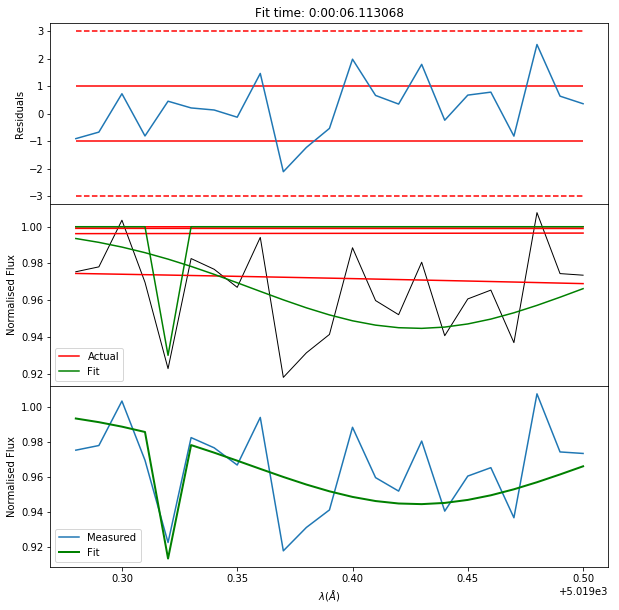

n:  2
Fit 1 BIC:  -1439.8477938486233 , Fit 2 BIC:  -3192.8878146423226
Fit 1 CS: 0.000829130756798985 | Fit 2 CS: 1.3572621708265037e-06
BIC Ratio:  0.4509547085386461
n:  3
Fit 1 BIC:  -3192.8878146423226 , Fit 2 BIC:  -3085.8217146352567
Fit 1 CS: 1.3572621708265037e-06 | Fit 2 CS: 2.5916281896897956e-06
BIC Ratio:  1.034696139280918
Using Adaptive Metropolis step method for each parameter.
 [-----------------100%-----------------] 15000 of 15000 complete in 14.3 sec
Took: 0:00:14.314360  to finish.


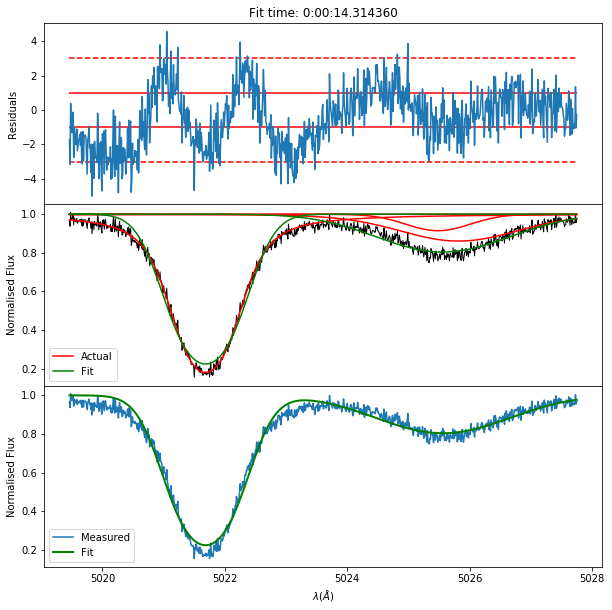

In [25]:
fits = []

for i in range(len(region_arrays)):
    
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n)
    vpfit_2.map_estimate()

    while((r < 1) or (vpfits.VPfit.Chisquared(vpfit_2.total.value, fluxes, vpfit_2.std_deviation) > 1.5)):

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map_estimate()

        print "Fit 1 BIC: ", vpfit_1.map.BIC, ", Fit 2 BIC: ", vpfit_2.map.BIC
        
        print "Fit 1 CS:", vpfits.VPfit.Chisquared(vpfit_1.total.value, fluxes, vpfit_1.std_deviation), "| Fit 2 CS:", \
            vpfits.VPfit.Chisquared(vpfit_2.total.value, fluxes, vpfit_2.std_deviation)
            
        print "BIC Ratio: ", vpfit_1.map.BIC / vpfit_2.map.BIC

        r = vpfit_1.map.BIC / vpfit_2.map.BIC
    
    n -= 1
    #print "n (final): ", n
    
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    vpfit_1.plot(wavelengths, fluxes, clouds, n, start_pix=start, end_pix=end)

Finally, we can plot the detection regions and the fitted profiles over the entire spectrum.

/home/sarah/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


Text(0,0.5,u'Normalised Flux')

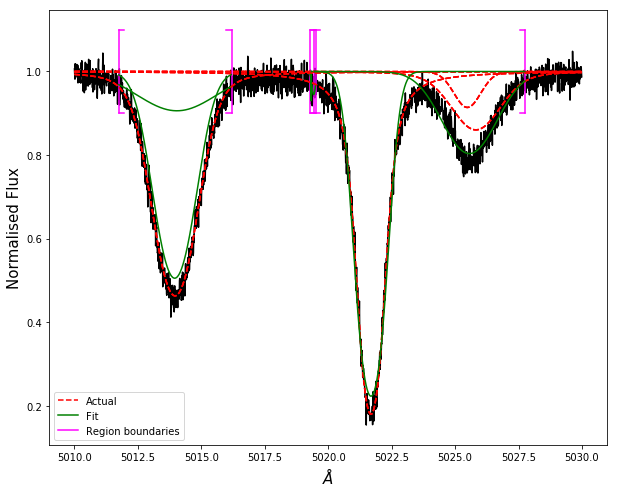

In [28]:
fig, ax = pylab.subplots(figsize=(10,8))

ax.plot(wavelength_array, flux_array, c='black')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')

for i in range(len(fits)):
    fit = fits[i]
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    for c in range(len(clouds)):
        ax.plot(wavelength_array, Tau2flux(clouds.ix[c]['tau']), color="red", ls='--')
        
    for prof in fit.estimated_profiles:
        ax.plot(wavelengths, Tau2flux(prof.value), color='green', lw=1.5)
        

handles = [mlines.Line2D([], [], color='red', label='Actual', ls='--'), mlines.Line2D([], [], color='green', label='Fit'),
          mlines.Line2D([], [], color='magenta', label='Region boundaries')]

ax.legend(handles=handles, prop={'size':10}, loc='best')

ax.set_xlabel('$\AA$', size=15)
ax.set_ylabel('Normalised Flux', size=15)